<a href="https://colab.research.google.com/github/aexomir/AML_mistake_detection/blob/feat%2Ferror-analysis-v2/notebooks/error_type_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error-Type-Aware Analysis for SupervisedER Task

This notebook runs per-error-type performance analysis for the SupervisedER task.

## Prerequisites:
You need to have:
- Pre-extracted features (Omnivore and SlowFast) in `.npz` format
- Checkpoints from the official release (`error_recognition_best` directory)
- Annotation files (should be in the repository or uploaded separately)

## Quick Start:
1. Upload your data to Google Drive (or use direct upload)
2. Configure paths in Section 1
3. Run all cells sequentially


In [1]:
# ============================================
# CONFIGURE YOUR REPOSITORY
# ============================================
# Option 1: Clone from GitHub (recommended)
REPO_URL = "https://github.com/aexomir/AML_mistake_detection.git"
REPO_BRANCH = "feat/error-type-analysis-v2"  # Leave empty for default branch, or specify branch name

# Option 2: Manual upload - set REPO_URL to empty string and upload files manually
# REPO_URL = ""

REPO_DIR = "aml_repo"

print(f"Repository URL: {REPO_URL if REPO_URL else 'Manual upload mode'}")
print(f"Repository branch: {REPO_BRANCH if REPO_BRANCH else 'default'}")
print(f"Repository directory: {REPO_DIR}")


Repository URL: https://github.com/aexomir/AML_mistake_detection.git
Repository branch: feat/error-type-analysis-v2
Repository directory: aml_repo


In [2]:
import os
import shutil

# Remove existing directory if it exists
if os.path.exists(REPO_DIR):
    print(f"Removing existing {REPO_DIR} directory...")
    shutil.rmtree(REPO_DIR)

# Clone repository
if REPO_URL:
    print(f"Cloning repository from {REPO_URL}...")
    clone_cmd = f"git clone {REPO_URL} {REPO_DIR}"
    result = os.system(clone_cmd)

    if result != 0:
        print(f"⚠ Clone failed. Please check the URL or upload files manually.")
        os.makedirs(REPO_DIR, exist_ok=True)
    else:
        print("✓ Repository cloned successfully")

        # Checkout specific branch if specified
        if REPO_BRANCH:
            print(f"Checking out branch: {REPO_BRANCH}")
            os.chdir(REPO_DIR)
            os.system(f"git checkout {REPO_BRANCH}")
            os.chdir('..')
            print(f"✓ Switched to branch: {REPO_BRANCH}")
else:
    print("Manual upload mode: Creating directory...")
    os.makedirs(REPO_DIR, exist_ok=True)

# Change to repository directory
if os.path.exists(REPO_DIR):
    os.chdir(REPO_DIR)
    print(f"\n✓ Changed to directory: {os.getcwd()}")
    print(f"\nRepository contents:")
    !ls -la
else:
    print(f"✗ Error: {REPO_DIR} directory not found!")


Cloning repository from https://github.com/aexomir/AML_mistake_detection.git...
✓ Repository cloned successfully
Checking out branch: feat/error-type-analysis-v2
✓ Switched to branch: feat/error-type-analysis-v2

✓ Changed to directory: /content/aml_repo

Repository contents:
total 6020
drwxr-xr-x 8 root root    4096 Dec 15 22:21 .
drwxr-xr-x 1 root root    4096 Dec 15 22:21 ..
-rw-r--r-- 1 root root 6042142 Dec 15 22:21 3_Mistake_Detection.pdf
-rw-r--r-- 1 root root   18838 Dec 15 22:21 base.py
-rw-r--r-- 1 root root    1661 Dec 15 22:21 constants.py
drwxr-xr-x 3 root root    4096 Dec 15 22:21 core
drwxr-xr-x 2 root root    4096 Dec 15 22:21 dataloader
-rw-r--r-- 1 root root    6148 Dec 15 22:21 .DS_Store
drwxr-xr-x 2 root root    4096 Dec 15 22:21 er_annotations
drwxr-xr-x 8 root root    4096 Dec 15 22:21 .git
-rw-r--r-- 1 root root      65 Dec 15 22:21 .gitignore
-rwxr-xr-x 1 root root    1904 Dec 15 22:21 install_deps.py
-rw-r--r-- 1 root root   11357 Dec 15 22:21 LICENSE
drwxr-xr-

In [3]:
# Install dependencies
# Colab comes with PyTorch pre-installed, so we'll work with that
# Remove PyTorch version constraints to avoid conflicts
if os.path.exists('requirements.txt'):
    !sed -i '/^torch==/d' requirements.txt 2>/dev/null || true
    !sed -i '/^torchvision==/d' requirements.txt 2>/dev/null || true

# Install torcheval (required for evaluation metrics)
%pip install -q torcheval

# Install all remaining dependencies from requirements.txt
if os.path.exists('requirements.txt'):
    %pip install -q -r requirements.txt
elif os.path.exists('requirements-cpu.txt'):
    %pip install -q -r requirements-cpu.txt

print("✓ All dependencies installed successfully")

# Verify PyTorch installation
import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.4.58 requires requests-toolbelt>=1.0.0, but you have requests-toolbelt 0.10.1 which is incompatible.
✓ All dependencies installed successfu

## 2. Load Data: Features, Checkpoints, and Annotations


In [4]:
# ============================================
# CONFIGURE DATA PATHS
# ============================================
# Option 1: From Google Drive (recommended for large files)
USE_GOOGLE_DRIVE = True  # Set to False if uploading directly

# Paths on Google Drive (update these to match your Drive structure)
OMNIVORE_DRIVE_PATH = "/content/drive/MyDrive/AML_mistake_detection/omnivore.zip"  # Can be .zip or directory
SLOWFAST_DRIVE_PATH = "/content/drive/MyDrive/AML_mistake_detection/slowfast.zip"  # Can be .zip or directory
CHECKPOINTS_DRIVE_PATH = "/content/drive/MyDrive/AML_mistake_detection/error_recognition_best.zip"  # Can be .zip or directory
ANNOTATIONS_DRIVE_PATH = "/content/drive/MyDrive/AML_mistake_detection/annotations"  # Optional if in repo

# Option 2: Direct upload - set USE_GOOGLE_DRIVE = False and upload files in next cell

print("Data paths configured:")
print(f"  Use Google Drive: {USE_GOOGLE_DRIVE}")
print(f"  Omnivore: {OMNIVORE_DRIVE_PATH}")
print(f"  SlowFast: {SLOWFAST_DRIVE_PATH}")
print(f"  Checkpoints: {CHECKPOINTS_DRIVE_PATH}")
print(f"  Annotations: {ANNOTATIONS_DRIVE_PATH}")


Data paths configured:
  Use Google Drive: True
  Omnivore: /content/drive/MyDrive/AML_mistake_detection/omnivore.zip
  SlowFast: /content/drive/MyDrive/AML_mistake_detection/slowfast.zip
  Checkpoints: /content/drive/MyDrive/AML_mistake_detection/error_recognition_best.zip
  Annotations: /content/drive/MyDrive/AML_mistake_detection/annotations


In [5]:
# Mount Google Drive if using it
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")
else:
    print("⚠ Google Drive not mounted. Please upload files directly using the file browser.")


Mounted at /content/drive
✓ Google Drive mounted


In [6]:
# Create data directory structure
import os
os.makedirs('data/video/omnivore', exist_ok=True)
os.makedirs('data/video/slowfast', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('annotations/annotation_json', exist_ok=True)
os.makedirs('annotations/data_splits', exist_ok=True)
os.makedirs('er_annotations', exist_ok=True)
os.makedirs('analysis/outputs', exist_ok=True)

print("✓ Directory structure created")


✓ Directory structure created


In [7]:
# Load features from Google Drive or direct upload
import os
import shutil
import subprocess
import glob

def load_features(source_path, dest_path, feature_name):
    """Load features from source (zip file or directory) to destination."""
    if not os.path.exists(source_path):
        print(f"⚠ {feature_name}: Source path not found: {source_path}")
        return False

    print(f"Loading {feature_name} features from: {source_path}")

    # Check if it's a zip file
    is_zip = source_path.lower().endswith('.zip') or (os.path.isfile(source_path) and 'zip' in str(source_path))

    if is_zip:
        print(f"  Detected zip file, extracting...")
        temp_zip = f'/tmp/{feature_name.lower()}.zip'
        temp_extracted = f'/tmp/{feature_name.lower()}_extracted'

        try:
            shutil.copy(source_path, temp_zip)
            subprocess.run(['unzip', '-q', temp_zip, '-d', temp_extracted], check=True)

            # Find .npz files in extracted directory
            npz_files = glob.glob(os.path.join(temp_extracted, '**/*.npz'), recursive=True)

            if npz_files:
                # Copy all .npz files to destination
                for npz_file in npz_files:
                    shutil.copy2(npz_file, dest_path)
                print(f"  ✓ Extracted and copied {len(npz_files)} .npz files")

                # Cleanup
                shutil.rmtree(temp_extracted, ignore_errors=True)
                os.remove(temp_zip)
                return True
            else:
                print(f"  ⚠ No .npz files found in extracted zip")
                shutil.rmtree(temp_extracted, ignore_errors=True)
                os.remove(temp_zip)
                return False
        except Exception as e:
            print(f"  ✗ Error extracting {feature_name} zip: {e}")
            if os.path.exists(temp_extracted):
                shutil.rmtree(temp_extracted, ignore_errors=True)
            if os.path.exists(temp_zip):
                os.remove(temp_zip)
            return False
    else:
        # It's a directory
        print(f"  Detected directory, copying .npz files...")
        npz_files = glob.glob(os.path.join(source_path, '**/*.npz'), recursive=True)

        if npz_files:
            # Copy all .npz files to destination
            for npz_file in npz_files:
                shutil.copy2(npz_file, dest_path)
            print(f"  ✓ Copied {len(npz_files)} .npz files")
            return True
        else:
            print(f"  ⚠ No .npz files found in {source_path}")
            return False

# Load Omnivore and SlowFast features
if USE_GOOGLE_DRIVE:
    load_features(OMNIVORE_DRIVE_PATH, 'data/video/omnivore', 'Omnivore')
    load_features(SLOWFAST_DRIVE_PATH, 'data/video/slowfast', 'SlowFast')
else:
    print("⚠ Please upload features manually:")
    print("  1. Use the file browser to upload .npz files or zip files")
    print("  2. Extract/copy them to data/video/omnivore/ and data/video/slowfast/")

# Verify features
omnivore_count = len([f for f in os.listdir('data/video/omnivore') if f.endswith('.npz')]) if os.path.exists('data/video/omnivore') else 0
slowfast_count = len([f for f in os.listdir('data/video/slowfast') if f.endswith('.npz')]) if os.path.exists('data/video/slowfast') else 0
print(f"\nFeature file counts:")
print(f"  Omnivore: {omnivore_count} .npz files")
print(f"  SlowFast: {slowfast_count} .npz files")


Loading Omnivore features from: /content/drive/MyDrive/AML_mistake_detection/omnivore.zip
  Detected zip file, extracting...
  ✓ Extracted and copied 384 .npz files
Loading SlowFast features from: /content/drive/MyDrive/AML_mistake_detection/slowfast.zip
  Detected zip file, extracting...
  ✓ Extracted and copied 384 .npz files

Feature file counts:
  Omnivore: 384 .npz files
  SlowFast: 384 .npz files


In [8]:
# Load checkpoints
import os
import shutil
import subprocess

checkpoint_path = CHECKPOINTS_DRIVE_PATH if USE_GOOGLE_DRIVE else None

if checkpoint_path and os.path.exists(checkpoint_path):
    print(f"Loading checkpoints from: {checkpoint_path}")

    # Check if it's a zip file
    is_zip = checkpoint_path.lower().endswith('.zip') or (os.path.isfile(checkpoint_path) and 'zip' in str(checkpoint_path))

    if is_zip:
        print("Detected zip file, extracting...")
        shutil.copy(checkpoint_path, '/tmp/checkpoints.zip')

        try:
            subprocess.run(['unzip', '-q', '/tmp/checkpoints.zip', '-d', '/tmp/checkpoints_extracted'], check=True)

            # Find error_recognition_best directory
            extracted_base = '/tmp/checkpoints_extracted'
            extracted_path = None

            # Check common locations
            if os.path.exists(os.path.join(extracted_base, 'error_recognition_best')):
                extracted_path = os.path.join(extracted_base, 'error_recognition_best')
            elif os.path.exists(os.path.join(extracted_base, 'MLP')) or os.path.exists(os.path.join(extracted_base, 'Transformer')):
                extracted_path = extracted_base
            else:
                # Search recursively
                for root, dirs, files in os.walk(extracted_base):
                    if 'error_recognition_best' in dirs:
                        extracted_path = os.path.join(root, 'error_recognition_best')
                        break
                    if 'MLP' in dirs or 'Transformer' in dirs:
                        extracted_path = root
                        break

                if extracted_path is None:
                    extracted_path = extracted_base

            print(f"Copying from: {extracted_path}")
            shutil.copytree(extracted_path, 'checkpoints/error_recognition_best', dirs_exist_ok=True)

            # Cleanup
            shutil.rmtree('/tmp/checkpoints_extracted', ignore_errors=True)
            os.remove('/tmp/checkpoints.zip')
            print("✓ Checkpoints extracted")
        except Exception as e:
            print(f"✗ Error extracting checkpoints: {e}")
    else:
        # It's a directory
        print("Detected directory, copying...")
        if os.path.basename(checkpoint_path) == 'error_recognition_best':
            shutil.copytree(checkpoint_path, 'checkpoints/error_recognition_best', dirs_exist_ok=True)
        else:
            os.makedirs('checkpoints/error_recognition_best', exist_ok=True)
            for item in os.listdir(checkpoint_path):
                src = os.path.join(checkpoint_path, item)
                dst = os.path.join('checkpoints/error_recognition_best', item)
                if os.path.isdir(src):
                    shutil.copytree(src, dst, dirs_exist_ok=True)
                else:
                    shutil.copy2(src, dst)
        print("✓ Checkpoints copied")
else:
    print("⚠ Checkpoints not found. Please upload manually:")
    print("  1. Download from: https://utdallas.app.box.com/s/uz3s1alrzucz03sleify8kazhuc1ksl3")
    print("  2. Extract error_recognition_best directory")
    print("  3. Upload to checkpoints/error_recognition_best/")

# Verify checkpoints
if os.path.exists('checkpoints/error_recognition_best'):
    pt_files = []
    for root, dirs, files in os.walk('checkpoints/error_recognition_best'):
        pt_files.extend([os.path.join(root, f) for f in files if f.endswith('.pt')])
    print(f"\n✓ Found {len(pt_files)} checkpoint files")
    if pt_files:
        print("\nSample checkpoint files:")
        for f in pt_files[:3]:
            print(f"  {f}")
else:
    print("\n✗ Checkpoints directory not found")


Loading checkpoints from: /content/drive/MyDrive/AML_mistake_detection/error_recognition_best.zip
Detected zip file, extracting...
Copying from: /tmp/checkpoints_extracted/error_recognition_best
✓ Checkpoints extracted

✓ Found 54 checkpoint files

Sample checkpoint files:
  checkpoints/error_recognition_best/Transformer/imagebind/error_recognition_Transformer_imagebind_audio_recordings_epoch_31.pt
  checkpoints/error_recognition_best/Transformer/imagebind/error_recognition_Transformer_imagebind_audio_step_epoch_44.pt
  checkpoints/error_recognition_best/Transformer/imagebind/error_recognition_Transformer_imagebind_video_audio_step_epoch_9.pt


In [9]:
# Load annotations (if not already in repository)
import os
import shutil

if USE_GOOGLE_DRIVE and os.path.exists(ANNOTATIONS_DRIVE_PATH):
    print(f"Loading annotations from: {ANNOTATIONS_DRIVE_PATH}")

    # Copy annotation_json
    annotation_json_src = os.path.join(ANNOTATIONS_DRIVE_PATH, 'annotation_json')
    if os.path.exists(annotation_json_src):
        for file in os.listdir(annotation_json_src):
            src = os.path.join(annotation_json_src, file)
            dst = os.path.join('annotations/annotation_json', file)
            if os.path.isfile(src):
                shutil.copy2(src, dst)
                print(f"  ✓ Copied {file}")

    # Copy data_splits
    data_splits_src = os.path.join(ANNOTATIONS_DRIVE_PATH, 'data_splits')
    if os.path.exists(data_splits_src):
        for file in os.listdir(data_splits_src):
            src = os.path.join(data_splits_src, file)
            dst = os.path.join('annotations/data_splits', file)
            if os.path.isfile(src):
                shutil.copy2(src, dst)
                print(f"  ✓ Copied {file}")

    # Copy er_annotations
    er_annotations_src = os.path.join(ANNOTATIONS_DRIVE_PATH, 'er_annotations')
    if os.path.exists(er_annotations_src):
        for file in os.listdir(er_annotations_src):
            src = os.path.join(er_annotations_src, file)
            dst = os.path.join('er_annotations', file)
            if os.path.isfile(src):
                shutil.copy2(src, dst)
                print(f"  ✓ Copied {file}")
else:
    print("⚠ Annotations not found in Drive. Checking repository...")

# Verify required annotation files
print("\nVerifying annotation files...")
required_files = [
    'annotations/annotation_json/step_annotations.json',
    'annotations/annotation_json/error_annotations.json',
    'er_annotations/recordings_combined_splits.json'
]

missing = []
for file in required_files:
    if os.path.exists(file):
        print(f"✓ Found: {file}")
    else:
        print(f"✗ Missing: {file}")
        missing.append(file)

if missing:
    print(f"\n⚠ Warning: {len(missing)} required annotation file(s) are missing!")
    print("Please ensure these files are available before running the analysis.")
else:
    print("\n✓ All required annotation files are present!")


Loading annotations from: /content/drive/MyDrive/AML_mistake_detection/annotations
  ✓ Copied error_category_idx.json
  ✓ Copied activity_idx_step_idx.json
  ✓ Copied error_annotations.json
  ✓ Copied step_annotations.json
  ✓ Copied complete_step_annotations.json
  ✓ Copied step_idx_description.json
  ✓ Copied recording_id_step_idx.json
  ✓ Copied environment_data_split_combined.json
  ✓ Copied person_data_split_normal.json
  ✓ Copied recordings_data_split_normal.json
  ✓ Copied person_data_split_combined.json
  ✓ Copied environment_data_split_normal.json
  ✓ Copied recordings_data_split_combined.json
  ✓ Copied recipes_data_split_normal.json
  ✓ Copied recipes_data_split_combined.json

Verifying annotation files...
✓ Found: annotations/annotation_json/step_annotations.json
✓ Found: annotations/annotation_json/error_annotations.json
✓ Found: er_annotations/recordings_combined_splits.json

✓ All required annotation files are present!


## 3. Run Error-Type Analysis

Run the analysis script with your model checkpoint and configuration.

**Note**: Use threshold 0.6 for `step` split and 0.4 for `recordings` split.


In [16]:
# Example: Omnivore - MLP - Step split
# This should reproduce: F1=24.26, AUC=75.74
# Make sure we're in the repository root directory
import os
if not os.path.exists('analysis/error_type_analysis.py'):
    print("Error: analysis/error_type_analysis.py not found. Current directory:", os.getcwd())
else:
    !python analysis/error_type_analysis.py \
        --split step \
        --backbone omnivore \
        --variant MLP \
        --ckpt checkpoints/error_recognition_best/MLP/omnivore/error_recognition_MLP_omnivore_step_epoch_43.pt \
        --threshold 0.6 \
        --output-dir analysis/outputs


Error-Type-Aware Analysis
Configuration:
  Split: step
  Backbone: omnivore
  Variant: MLP
  Threshold: 0.6
  Step normalization: True
  Sub-step normalization: True

Loading model...
Loading test dataset...
Loaded annotations...... 
Loading recording ids from recordings_combined_splits.json
Running inference...
Running inference: 100% 798/798 [00:09<00:00, 84.65it/s]
Collected 42347 sample records

Per-Error-Type Performance Metrics
       error_type  error_label accuracy precision recall     f1  sample_count    auc
     Global (All)          NaN   0.6831    0.4096 0.2990 0.3457         42347 0.6542
         No Error          0.0   0.7388    0.3060 0.3257 0.3155         37408 0.6590
     Timing Error          5.0   0.2303    1.0000 0.2303 0.3744          2835    N/A
Preparation Error          2.0   0.2807    1.0000 0.2807 0.4384          2230    N/A
  Technique Error          6.0   0.3890    1.0000 0.3890 0.5601          2211    N/A
Measurement Error          4.0   0.2961    1.0000 0.

In [17]:
# Example: Omnivore - Transformer - Step split
# This should reproduce: F1=55.39, AUC=75.62
# Update the epoch number in the checkpoint path
import os
if not os.path.exists('analysis/error_type_analysis.py'):
    print("Error: analysis/error_type_analysis.py not found. Current directory:", os.getcwd())
else:
    !python analysis/error_type_analysis.py \
        --split step \
        --backbone omnivore \
        --variant Transformer \
        --ckpt checkpoints/error_recognition_best/Transformer/omnivore/error_recognition_Transformer_omnivore_step_epoch_9.pt \
        --threshold 0.6 \
        --output-dir analysis/outputs


Error-Type-Aware Analysis
Configuration:
  Split: step
  Backbone: omnivore
  Variant: Transformer
  Threshold: 0.6
  Step normalization: True
  Sub-step normalization: True

Loading model...
Loading test dataset...
Loaded annotations...... 
Loading recording ids from recordings_combined_splits.json
Running inference...
Running inference: 100% 798/798 [00:05<00:00, 147.63it/s]
Collected 42347 sample records

Per-Error-Type Performance Metrics
       error_type  error_label accuracy precision recall     f1  sample_count    auc
     Global (All)          NaN   0.6739    0.4445 0.6614 0.5317         42347 0.7462
         No Error          0.0   0.6727    0.3132 0.6461 0.4219         37408 0.7440
     Timing Error          5.0   0.6568    1.0000 0.6568 0.7928          2835    N/A
Preparation Error          2.0   0.6238    1.0000 0.6238 0.7683          2230    N/A
  Technique Error          6.0   0.5975    1.0000 0.5975 0.7480          2211    N/A
Measurement Error          4.0   0.6922    

In [18]:
# Example: Omnivore - MLP - Recordings split
# This should reproduce: F1=55.42, AUC=63.03
# Update the epoch number in the checkpoint path
import os
if not os.path.exists('analysis/error_type_analysis.py'):
    print("Error: analysis/error_type_analysis.py not found. Current directory:", os.getcwd())
else:
    !python analysis/error_type_analysis.py \
        --split recordings \
        --backbone omnivore \
        --variant MLP \
        --ckpt checkpoints/error_recognition_best/MLP/omnivore/error_recognition_MLP_omnivore_recordings_epoch_33.pt \
        --threshold 0.4 \
        --output-dir analysis/outputs


Error-Type-Aware Analysis
Configuration:
  Split: recordings
  Backbone: omnivore
  Variant: MLP
  Threshold: 0.4
  Step normalization: True
  Sub-step normalization: True

Loading model...
Loading test dataset...
Loaded annotations...... 
Loading recording ids from recordings_combined_splits.json
Running inference...
Running inference: 100% 671/671 [00:03<00:00, 172.93it/s]
Collected 38340 sample records

Per-Error-Type Performance Metrics
       error_type  error_label accuracy precision recall     f1  sample_count    auc
     Global (All)          NaN   0.5735    0.3965 0.5688 0.4673         38340 0.5988
         No Error          0.0   0.5726    0.2683 0.5609 0.3630         32868 0.5952
Measurement Error          4.0   0.6500    1.0000 0.6500 0.7879          3354    N/A
     Timing Error          5.0   0.5629    1.0000 0.5629 0.7203          2711    N/A
  Technique Error          6.0   0.5169    1.0000 0.5169 0.6815          2668    N/A
Preparation Error          2.0   0.6091    1.

In [19]:
# Example: Omnivore - Transformer - Recordings split
# This should reproduce: F1=40.73, AUC=62.27
# Update the epoch number in the checkpoint path
import os
if not os.path.exists('analysis/error_type_analysis.py'):
    print("Error: analysis/error_type_analysis.py not found. Current directory:", os.getcwd())
else:
    !python analysis/error_type_analysis.py \
        --split recordings \
        --backbone omnivore \
        --variant Transformer \
        --ckpt checkpoints/error_recognition_best/Transformer/omnivore/error_recognition_Transformer_omnivore_recordings_epoch_31.pt \
        --threshold 0.4 \
        --output-dir analysis/outputs


Error-Type-Aware Analysis
Configuration:
  Split: recordings
  Backbone: omnivore
  Variant: Transformer
  Threshold: 0.4
  Step normalization: True
  Sub-step normalization: True

Loading model...
Loading test dataset...
Loaded annotations...... 
Loading recording ids from recordings_combined_splits.json
Running inference...
Running inference: 100% 671/671 [00:04<00:00, 140.91it/s]
Collected 38340 sample records

Per-Error-Type Performance Metrics
       error_type  error_label accuracy precision recall     f1  sample_count    auc
     Global (All)          NaN   0.6450    0.4491 0.3512 0.3942         38340 0.6254
         No Error          0.0   0.6965    0.3231 0.3633 0.3420         32868 0.6391
Measurement Error          4.0   0.5280    1.0000 0.5280 0.6911          3354    N/A
     Timing Error          5.0   0.2497    1.0000 0.2497 0.3996          2711    N/A
  Technique Error          6.0   0.3834    1.0000 0.3834 0.5543          2668    N/A
Preparation Error          2.0   0.30

In [14]:
# List available checkpoints to find correct epoch numbers
import os
import glob

checkpoint_base = 'checkpoints/error_recognition_best'
if os.path.exists(checkpoint_base):
    print("Available checkpoints:")
    for ckpt_file in sorted(glob.glob(os.path.join(checkpoint_base, '**/*.pt'), recursive=True)):
        print(f"  {ckpt_file}")
else:
    print("Checkpoints directory not found")


Available checkpoints:
  checkpoints/error_recognition_best/MLP/3dresnet/error_recognition_MLP_3dresnet_environment_epoch_11.pt
  checkpoints/error_recognition_best/MLP/3dresnet/error_recognition_MLP_3dresnet_person_epoch_39.pt
  checkpoints/error_recognition_best/MLP/3dresnet/error_recognition_MLP_3dresnet_recordings_epoch_45.pt
  checkpoints/error_recognition_best/MLP/3dresnet/error_recognition_MLP_3dresnet_step_epoch_41.pt
  checkpoints/error_recognition_best/MLP/imagebind/error_recognition_MLP_imagebind_audio_environment_epoch_50.pt
  checkpoints/error_recognition_best/MLP/imagebind/error_recognition_MLP_imagebind_audio_person_epoch_8.pt
  checkpoints/error_recognition_best/MLP/imagebind/error_recognition_MLP_imagebind_audio_recordings_epoch_2.pt
  checkpoints/error_recognition_best/MLP/imagebind/error_recognition_MLP_imagebind_audio_step_epoch_28.pt
  checkpoints/error_recognition_best/MLP/imagebind/error_recognition_MLP_imagebind_video_audio_environment_epoch_31.pt
  checkpoints/

## 4. Display Results

Load and display the results from the analysis.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results CSV
results_df = pd.read_csv('analysis/outputs/error_type_analysis_step_omnivore_MLP_threshold_0.6.csv')

# Display table
print("Per-Error-Type Performance Metrics:")
print("=" * 80)
display(results_df)


Per-Error-Type Performance Metrics:


,error_type,error_label,accuracy,precision,recall,f1,sample_count,auc
0,Global (All),NaN,0.683142,0.409616,0.298971,0.345655,42347,0.654156
1,No Error,0.0,0.738799,0.305978,0.325669,0.315517,37408,0.659001
2,Timing Error,5.0,0.230335,1.000000,0.230335,0.374427,2835,NaN
3,Preparation Error,2.0,0.280717,1.000000,0.280717,0.438375,2230,NaN
4,Technique Error,6.0,0.388964,1.000000,0.388964,0.560078,2211,NaN
5,Measurement Error,4.0,0.296119,1.000000,0.296119,0.456932,1881,NaN
6,Temperature Error,3.0,0.193989,1.000000,0.193989,0.324943,732,NaN


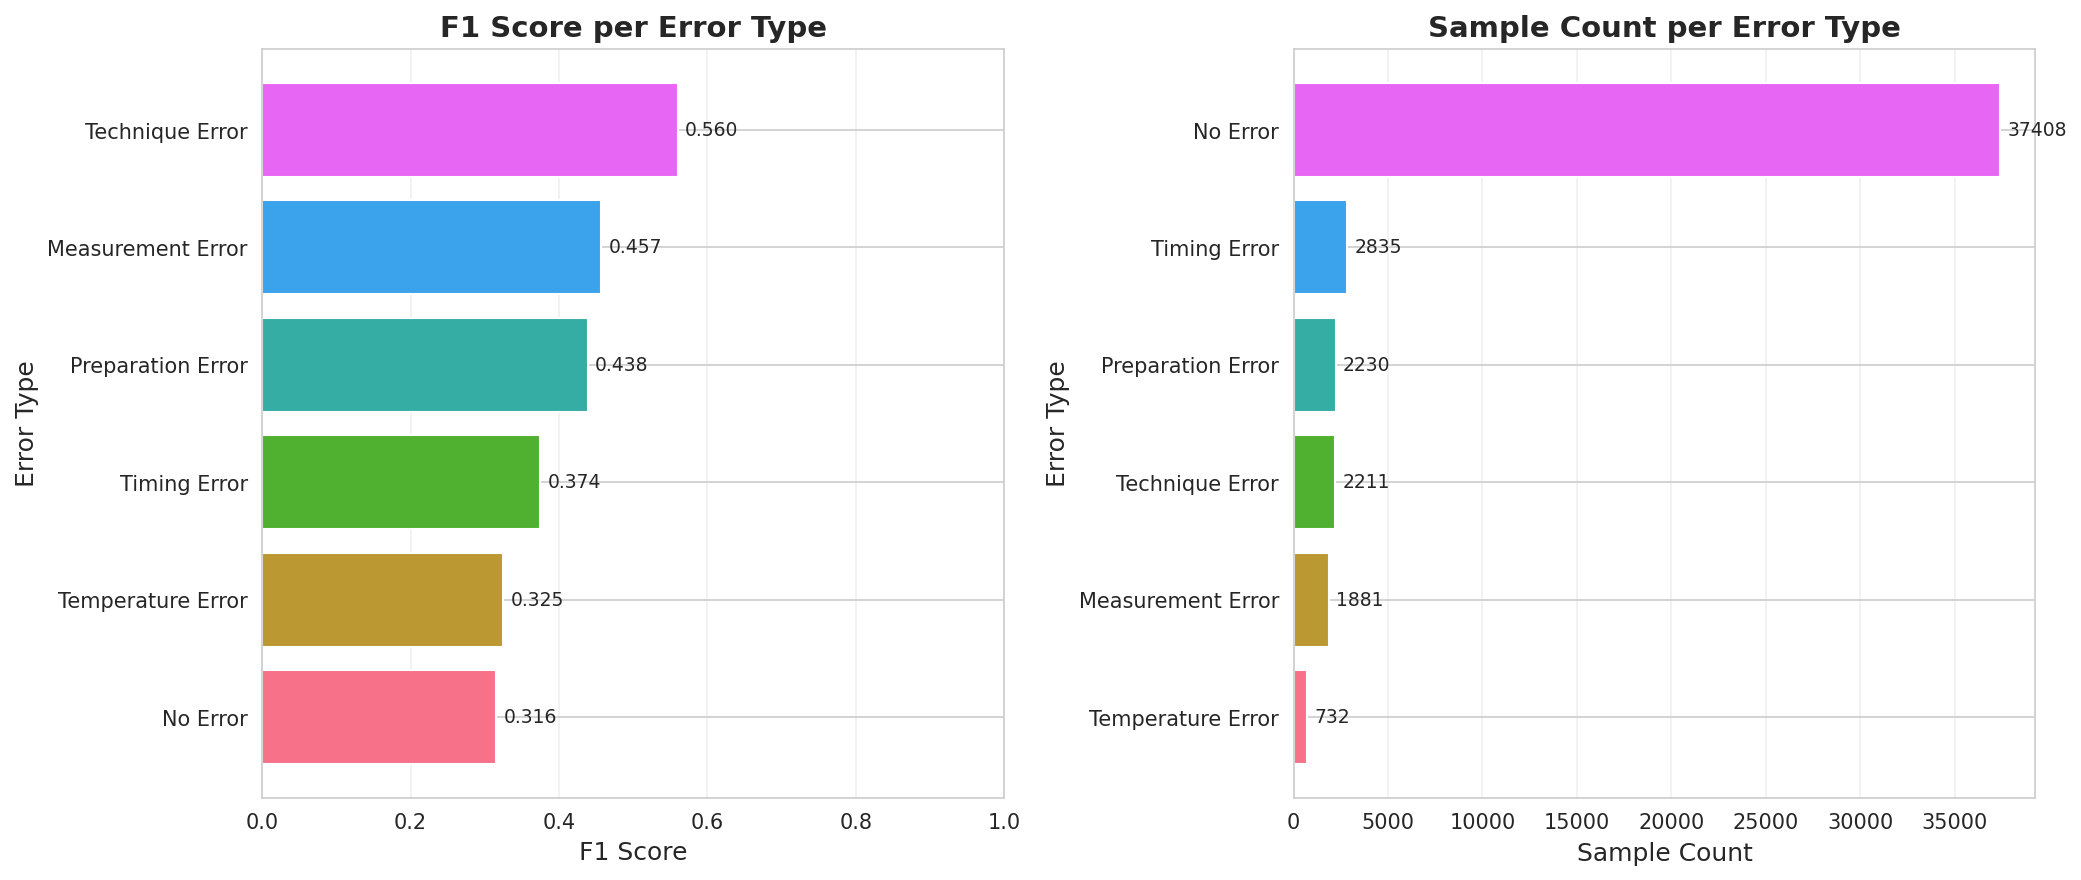

In [21]:
# Display saved plots
from IPython.display import Image, display

fig_path = 'analysis/outputs/error_type_analysis_step_omnivore_MLP_threshold_0.6.png'
if os.path.exists(fig_path):
    display(Image(fig_path))
else:
    print(f"Plot not found at {fig_path}")
